In [20]:
import sys
import os
import struct
import time
import numpy as np
import h5py
from scipy.io import loadmat
from scipy.stats import pearsonr
from tqdm import tqdm
import pickle
import math
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
%matplotlib inline

fpX = np.float32

import torch 
sys.path.append('/user_data/mmhender/imStat/fwrf_code_from_osf/')
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict
from src.gabor_feature_extractor import Gaborizer
from src.torch_fwrf import get_value, set_value
from src.rf_grid import linspace, logspace
import src.numpy_utility as pnu
from src.file_utility import save_stuff, flatten_dict, embed_dict
from src.load_nsd import image_uncolorize_fn

In [21]:
device = torch.device('cpu:0')

In [22]:
print ('#device:', torch.cuda.device_count())
print ('device#:', torch.cuda.current_device())
print ('device name:', torch.cuda.get_device_name(torch.cuda.current_device()))

torch.manual_seed(time.time())
device = torch.device("cuda:0") #cuda
torch.backends.cudnn.enabled=True

print ('\ntorch:', torch.__version__)
print ('cuda: ', torch.version.cuda)
print ('cudnn:', torch.backends.cudnn.version())
print ('dtype:', torch.get_default_dtype())
#torch.set_default_dtype(torch.float64)

#device: 1
device#: 0
device name: GeForce GTX TITAN X

torch: 1.8.1+cu111
cuda:  11.1
cudnn: 8005
dtype: torch.float32


In [23]:
sns.axes_style()
sns.set_style("white")
sns.set_context("notebook", rc={'axes.labelsize': 12.0, 'axes.titlesize': 14.0, 'legend.fontsize': 12.0, 'xtick.labelsize': 12.0, 'ytick.labelsize': 12.0})
sns.set_palette("deep")
plt.rcParams['image.cmap'] = 'viridis'

In [127]:
nsd_root = "/lab_data/tarrlab/common/datasets/NSD/"
stim_root = '/user_data/mmhender/nsd_stimuli/stimuli/nsd/'
mask_root = nsd_root + "nsddata/ppdata/"

subject = 1
saveext = ".png"
savearg = {'format':'png', 'dpi': 120, 'facecolor': None}

timestamp = 'Jun-09-2021_1319'
# timestamp = 'Jun-09-2021_2120'

model_name = 'gabor_fwrf'

root_dir   = os.path.dirname(os.getcwd())
net_dir    = root_dir + "net/" 

# input_dir  = '/home/styvesg/repo.data/results/nsd/torch_fwrf_full_brain/S%02d/dnn_fwrf_May-10-2020_1814/'
output_dir = os.path.join(root_dir, 'gabor_model_fits','S%02d'%subject,'%s_%s/'% (model_name,timestamp) )

group_names = ['V1', 'V2', 'V3', 'hV4', 'V3ab', 'LO', 'IPS', 'VO', 'PHC', 'MT', 'MST', 'other']
group = [[1,2],[3,4],[5,6], [7], [16, 17], [14, 15], [18,19,20,21,22,23], [8, 9], [10,11], [13], [12], [24,25,0]]
n_rois = len(group_names)


In [128]:
# Loading the results of model fitting performed with fit_model.py

fns = os.listdir(output_dir)
fns = [fn for fn in fns if 'model_params' in fn]
print(fns)
out = torch.load(os.path.join(output_dir, fns[0]))
print(out.keys())

['model_params_second_order_pca_allROIs']
dict_keys(['feature_table', 'sf_tuning_masks', 'ori_tuning_masks', 'cyc_per_stim', 'orients_deg', 'orient_filters', 'aperture', 'best_model_inds', 'models', 'voxel_mask', 'brain_nii_shape', 'image_order', 'voxel_index', 'voxel_roi', 'voxel_ncsnr', 'best_params', 'lambdas', 'best_losses', 'val_cc', 'val_r2', 'features_each_model_val', 'features_pca_each_model_val', 'voxel_feature_correlations_val', 'voxel_pca_feature_correlations_val', 'pc', 'second_order_zstats', 'zscore_features', 'nonlin_fn', 'padding_mode', 'debug'])


In [129]:
# Pulling out useful elements from the saved data

feature_table = out['feature_table']
orient_list = np.round(np.array(feature_table['orientation'])/np.pi*180,1)
a,orient_ind_list = np.unique(orient_list,return_inverse=True)
sf_list = np.array(feature_table['cycles per stimulus'])
a,sf_ind_list = np.unique(sf_list,return_inverse=True)

aperture = out['aperture']
cyc_per_stim  = out['cyc_per_stim']
orients_deg = out['orients_deg']

sf_tuning_masks = out['sf_tuning_masks']
ori_tuning_masks = out['ori_tuning_masks']
orient_filters = out['orient_filters']

voxel_mask = out['voxel_mask']
brain_nii_shape = out['brain_nii_shape']
image_order = out['image_order']
voxel_idx = out['voxel_index']
voxel_roi = out['voxel_roi']

val_cc = out['val_cc']
best_params = out['best_params']
best_lambdas = np.zeros(shape=np.shape(out['best_losses']), dtype=np.float)
best_losses = out['best_losses']
lambdas = out['lambdas']

features_each_model_val = out['features_each_model_val']
features_each_model_val = out['features_pca_each_model_val']
voxel_feature_correlations_val = out['voxel_feature_correlations_val']
voxel_pca_feature_correlations_val = out['voxel_pca_feature_correlations_val']
  
pc = out['pc']
pca_wts = pc[0]
pct_var_expl = pc[1]
n_comp_needed = pc[3]
pca_pre_mean = pc[4]

zscore_features = out['zscore_features']
nonlin_fn = out['nonlin_fn']

# Best params[0] = x,y,sigma for pRF estimates [n_voxels x 3]
print(np.shape(best_params[0]))
# Best params[1] = best weights [n_voxels x nFeatures]
print(np.shape(best_params[1]))

best_models = best_params[0]
best_model_inds = best_params[5]
best_ecc  = np.sqrt(np.square(best_models[:,0]) + np.square(best_models[:,1]))
best_ang  = np.arctan2(best_models[:,1], best_models[:,0])
best_size = best_models[:,2]

feature_weights = best_params[1]

n_sf = len(cyc_per_stim)
n_ori = len(orients_deg)
n_voxels = np.shape(feature_weights)[0]
n_features_total = np.shape(feature_weights)[1]

(11694, 3)
(11694, 600)


/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:25: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


In [130]:
orients_deg

array([  0. ,  22.5,  45. ,  67.5,  90. , 112.5, 135. , 157.5])

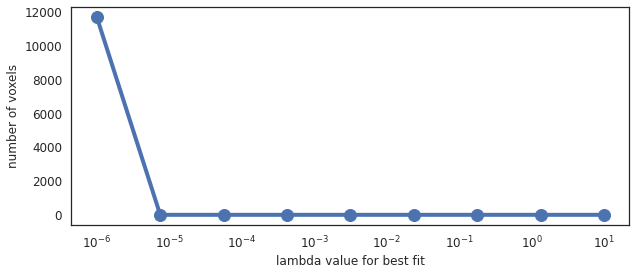

In [131]:
# Plot best lambda values for all voxels

plt.figure(figsize=(10,4))
# lambdas = np.logspace(0.,5.,9, dtype=np.float32)
plt.plot(lambdas, [np.sum(best_lambdas==k) for k in range(len(lambdas))], lw=4, marker='o', ms=12)
plt.xscale('log');
plt.xlabel('lambda value for best fit');
plt.ylabel('number of voxels');

In [48]:
np.shape(pct_var_expl)

(600, 875)

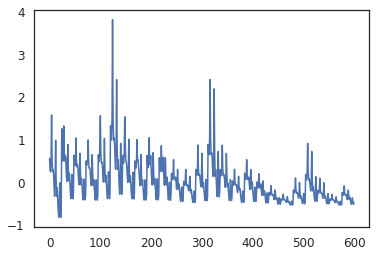

In [29]:
np.shape(pca_pre_mean)
plt.figure();
plt.plot(pca_pre_mean[:,0])
# plt.pcolormesh(np.transpose(pca_pre_mean))

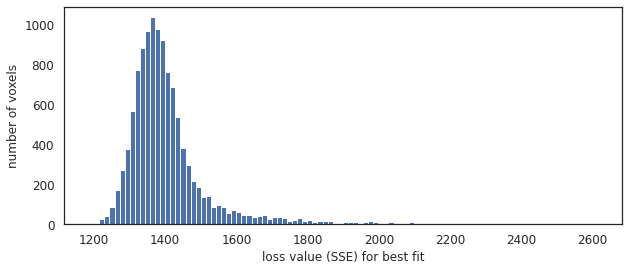

In [132]:
# Plot best loss values for all voxels

plt.figure(figsize=(10,4))
plt.hist(best_losses,100)
plt.xlabel('loss value (SSE) for best fit');
plt.ylabel('number of voxels');

/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  if __name__ == '__main__':


Text(0.5, 0.98, 'Correlation coef. on validation set')

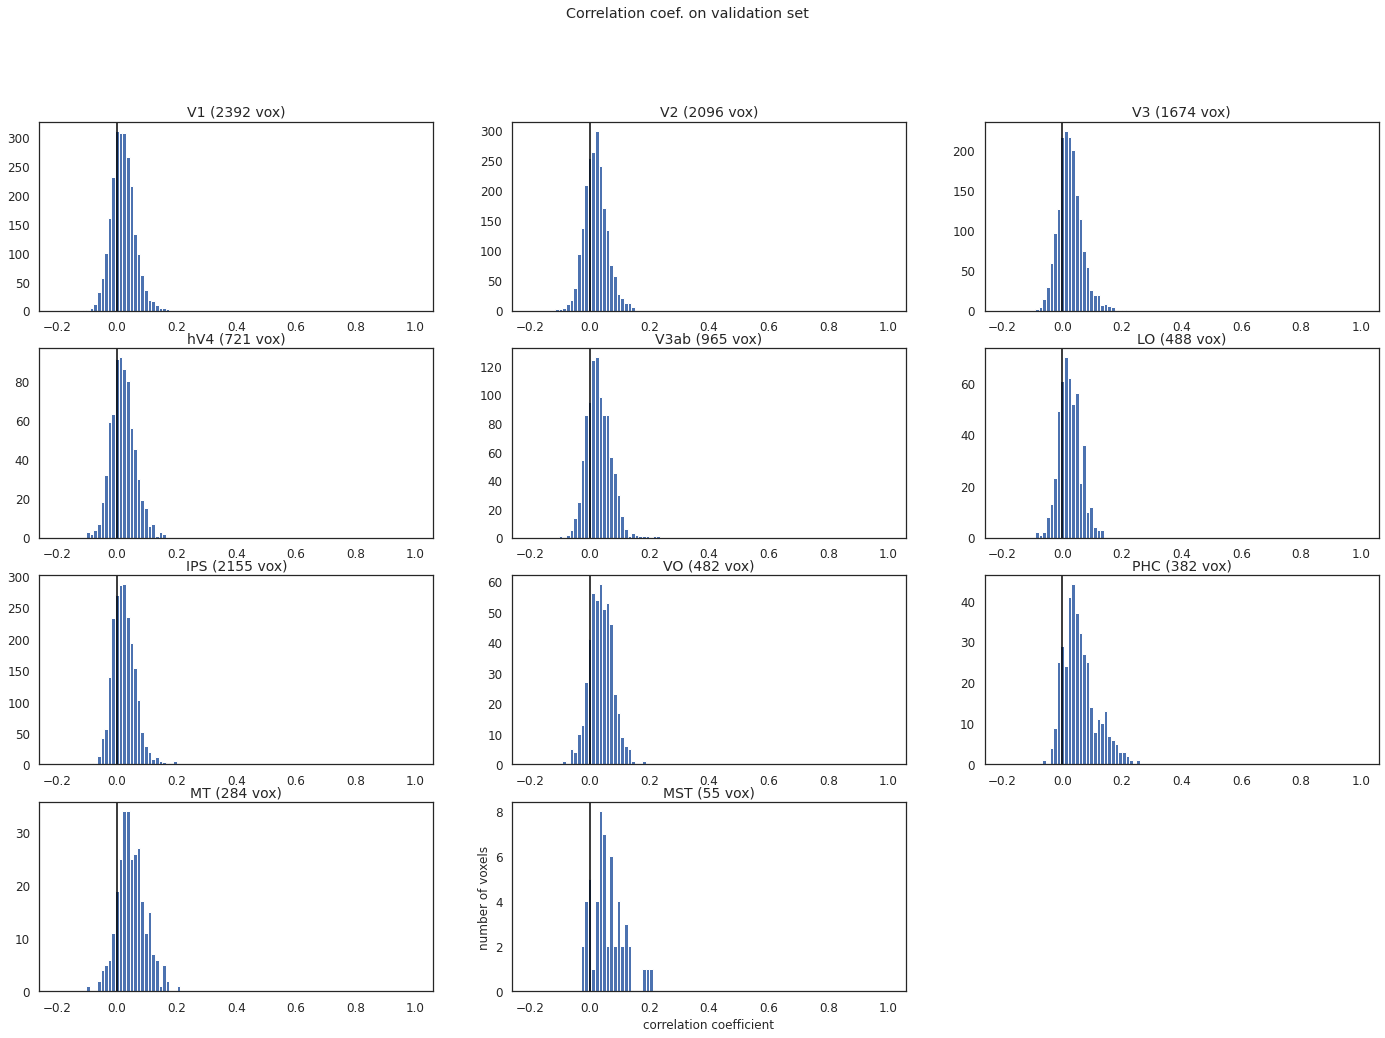

In [133]:
# Plot correlation coefficient for validation set, each voxel.
plt.figure(figsize=(24,16))
npx = np.ceil(np.sqrt(n_rois))
npy = np.ceil(n_rois/npx)

for rr in range(n_rois-1):
        
    inds_this_roi = np.isin(voxel_roi, group[rr])
    plt.subplot(npx,npy,rr+1)

    h = plt.hist(val_cc[inds_this_roi], bins=np.linspace(-0.2,1,100))

    if rr==n_rois-2:
        plt.xlabel('correlation coefficient')
        plt.ylabel('number of voxels')
#     else:
#         plt.xticks([])
#         plt.yticks([])
        
    plt.axvline(0,color='k')
    
    plt.title('%s (%d vox)'%(group_names[rr], np.sum(inds_this_roi)))

plt.suptitle('Correlation coef. on validation set')

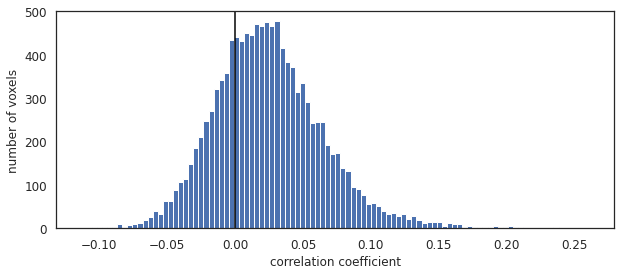

In [37]:
# Plot correlation coefficient for validation set, each voxel.

plt.figure(figsize=(10,4))
plt.hist(val_cc,100)
plt.xlabel('correlation coefficient');
plt.ylabel('number of voxels');
plt.axvline(0,color='k')


Text(0, 0.5, 'validation set rho')

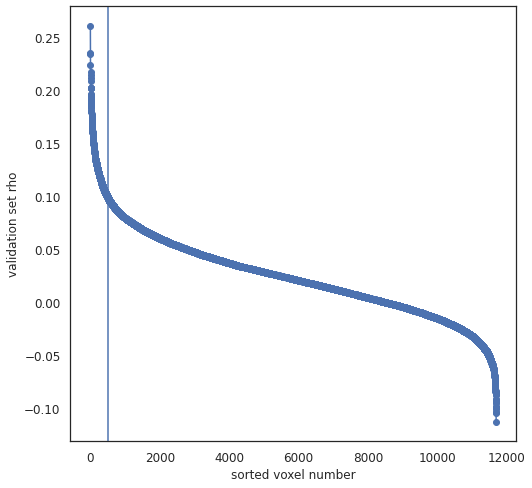

In [38]:
# Plot sorted correlation coefficients

plt.figure(figsize=(8,8))
# best_cc_vals = np.argsort(val_cc)
plt.plot(np.sort(val_cc)[::-1],'-o')
plt.axvline(500)
plt.xlabel('sorted voxel number')
plt.ylabel('validation set rho')

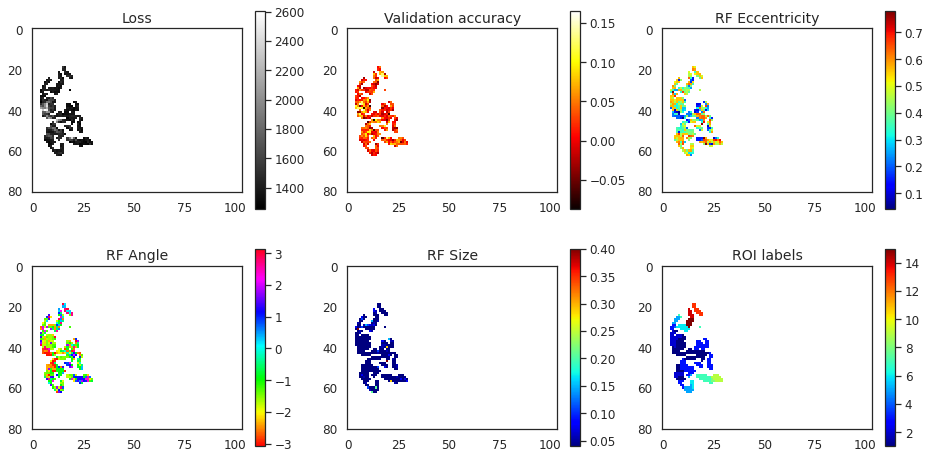

In [39]:
# Visualize some basic properties of pRFs for each voxel, in volume space
# Should be sanity check for dorsal/visual distinctions, esp w/r/t RF angle estimates

from src.file_utility import view_data

volume_loss = view_data(brain_nii_shape, voxel_idx, best_losses)
volume_cc   = view_data(brain_nii_shape, voxel_idx, val_cc, save_to=output_dir+"val_cc")
volume_ecc  = view_data(brain_nii_shape, voxel_idx, best_ecc, save_to=output_dir+"rf_ecc")
volume_ang  = view_data(brain_nii_shape, voxel_idx, best_ang, save_to=output_dir+"rf_ang")
volume_size = view_data(brain_nii_shape, voxel_idx, best_size, save_to=output_dir+"rf_size")
volume_roi = view_data(brain_nii_shape, voxel_idx, voxel_roi, save_to=output_dir+"roi_labels")

slice_idx = 40
fig = plt.figure(figsize=(16,8))
plt.subplot(2,3,1)
plt.title('Loss')
plt.imshow(volume_loss[:,:,slice_idx], cmap='gray', interpolation='None')
plt.colorbar()
plt.subplot(2,3,2)
plt.title('Validation accuracy')
plt.imshow(volume_cc[:,:,slice_idx], cmap='hot', interpolation='None')
plt.colorbar()
plt.subplot(2,3,3)
plt.title('RF Eccentricity')
plt.imshow(volume_ecc[:,:,slice_idx], cmap='jet', interpolation='None')
plt.colorbar()
plt.subplot(2,3,4)
plt.title('RF Angle')
plt.imshow(volume_ang[:,:,slice_idx], cmap='hsv', interpolation='None')
plt.colorbar()
plt.subplot(2,3,5)
plt.title('RF Size')
plt.imshow(volume_size[:,:,slice_idx], cmap='jet', interpolation='None')
plt.colorbar()
plt.subplot(2,3,6)
plt.title('ROI labels')
plt.imshow(volume_roi[:,:,slice_idx], cmap='jet', interpolation='None')
plt.colorbar()

In [41]:
# Assessing spatial frequency and orientation tuning

# allcorrs_reshaped = np.reshape(voxel_feature_correlations_val, [n_voxels, n_ori, n_sf], order='F')

# mean_orient_corrs = np.mean(allcorrs_reshaped, axis=2)
# print(np.shape(mean_orient_corrs))
# mean_sf_corrs = np.mean(allcorrs_reshaped, axis=1)
# print(np.shape(mean_sf_corrs))

# max_orient_corr_ind = np.argmax(mean_orient_corrs, axis=1)
# preferred_ori_corrs = orients_deg[max_orient_corr_ind]

# max_sf_corr_ind = np.argmax(mean_sf_corrs, axis=1)
# preferred_sf_corrs = cyc_per_stim[max_sf_corr_ind]



# allw_reshaped = np.reshape(feature_weights, [n_voxels, n_ori, n_sf], order='F')

# mean_orient_weights = np.mean(allw_reshaped, axis=2)
# print(np.shape(mean_orient_weights))
# mean_sf_weights = np.mean(allw_reshaped, axis=1)
# print(np.shape(mean_sf_weights))

# max_orient_weight_ind = np.argmax(mean_orient_weights, axis=1)
# preferred_ori_weights = orients_deg[max_orient_weight_ind]

# max_sf_weight_ind = np.argmax(mean_sf_weights, axis=1)
# preferred_sf_weights = cyc_per_stim[max_sf_weight_ind]


In [73]:
# double check that the reshaping was done correctly
# sf=0
# oo=0
# # print(allw_reshaped[0,:,sf])
# # print(feature_weights[0,sf_tuning_masks[sf]])
# print(allcorrs_reshaped[0,:,sf])
# print(voxel_feature_correlations_val[0,sf_tuning_masks[sf]])

# # print(allw_reshaped[0,oo,:])
# # print(feature_weights[0,ori_tuning_masks[oo]])
# print(allcorrs_reshaped[0,oo,:])
# print(voxel_feature_correlations_val[0,ori_tuning_masks[oo]])


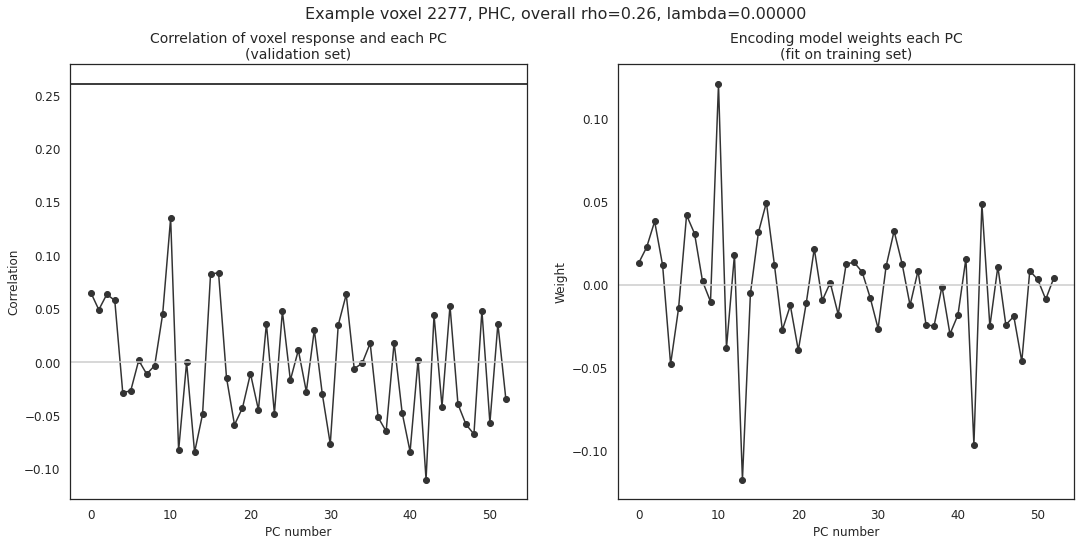

In [79]:
# Plotting weights for each PC


vidx = np.argsort(np.nan_to_num(val_cc))[-1] # choosing vox w best validation set performance
ncomp2use = n_comp_needed[best_model_inds[vidx]]
assert np.where(np.isnan(voxel_pca_feature_correlations_val[vidx,:]))[0][0]==ncomp2use
assert feature_weights[vidx,ncomp2use]==0.0 and not feature_weights[vidx,ncomp2use-1]==0.0

plt.figure(figsize=(18,8))

plt.subplot(1,2,1)
plt.plot(voxel_pca_feature_correlations_val[vidx,:],'-o',color=[0.2, 0.2, 0.2])
plt.xlabel('PC number')
plt.ylabel('Correlation')
plt.title('Correlation of voxel response and each PC\n(validation set)')
plt.axhline(val_cc[vidx],color='k')
plt.axhline(0, color=[0.8, 0.8, 0.8])

plt.subplot(1,2,2)
plt.plot(np.arange(0,ncomp2use,1), feature_weights[vidx,0:ncomp2use],'-o',color=[0.2, 0.2, 0.2])
plt.xlabel('PC number')
plt.ylabel('Weight')
plt.title('Encoding model weights each PC\n(fit on training set)')
plt.axhline(0, color=[0.8, 0.8, 0.8])

roi_ind = np.where([np.isin(voxel_roi[vidx], group[ii]) for ii in range(len(group))])[0][0]

plt.suptitle('Example voxel %d, %s, overall rho=%.2f, lambda=%.5f'%( vidx, group_names[roi_ind], val_cc[vidx],lambdas[int(best_lambdas[vidx])]),fontsize=16);

53


Text(0.5, 1.0, 'full feature space for one example RF position\nncomp = 53')

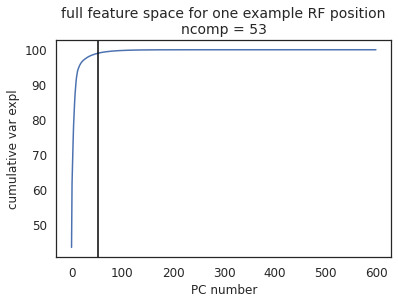

In [81]:
vidx = np.argsort(np.nan_to_num(val_cc))[-1] 
ncomp2use = n_comp_needed[best_model_inds[vidx]]
ve = pct_var_expl[:,best_model_inds[vidx]]

plt.figure()
plt.plot(np.cumsum(ve))
plt.axvline(ncomp2use,color='k')
print(ncomp2use)
plt.xlabel('PC number')
plt.ylabel('cumulative var expl')
plt.title('full feature space for one example RF position\nncomp = %d'%ncomp2use)

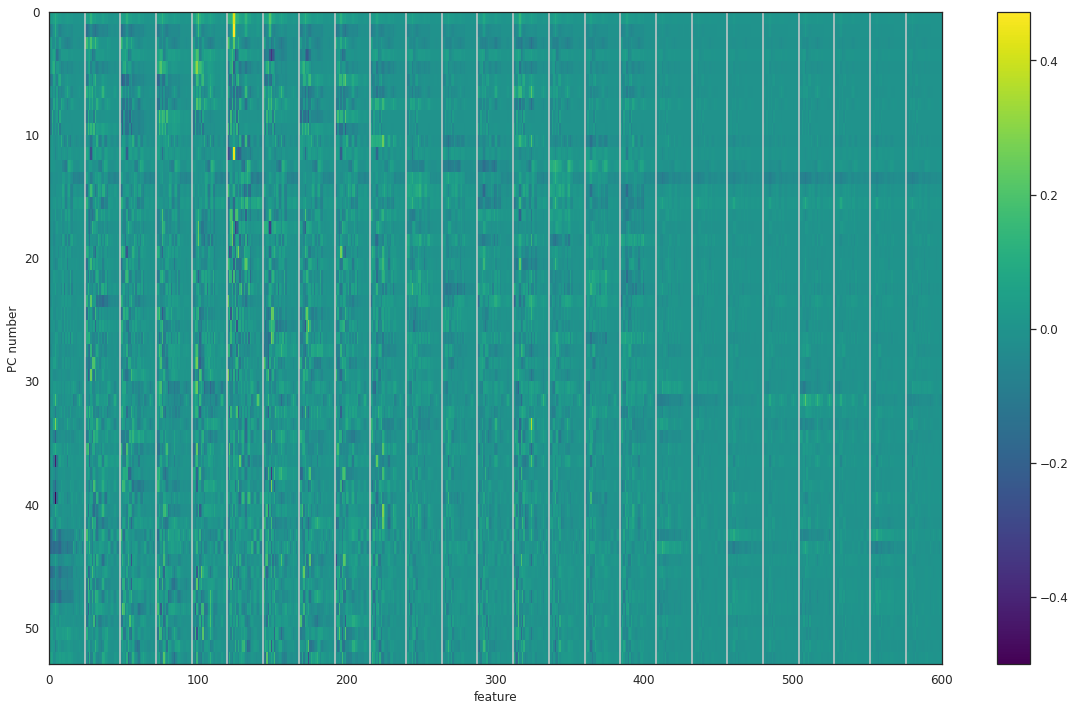

In [82]:
# visualize the PCs (feature space wts)
vidx = np.argsort(np.nan_to_num(val_cc))[-1] 
ncomp2use = n_comp_needed[best_model_inds[vidx]]
n_features = len(orients_deg)*len(cyc_per_stim)
plt.figure(figsize=(20,12));
plt.pcolormesh(pca_wts[0:ncomp2use,:, best_model_inds[vidx]])
for ii in np.arange(0,n_features*n_features+n_features, n_features):
    plt.axvline(ii,color=[0.8, 0.8, 0.8])
plt.xlabel('feature')
plt.ylabel('PC number')
plt.gca().invert_yaxis()
plt.colorbar()

/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:20: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


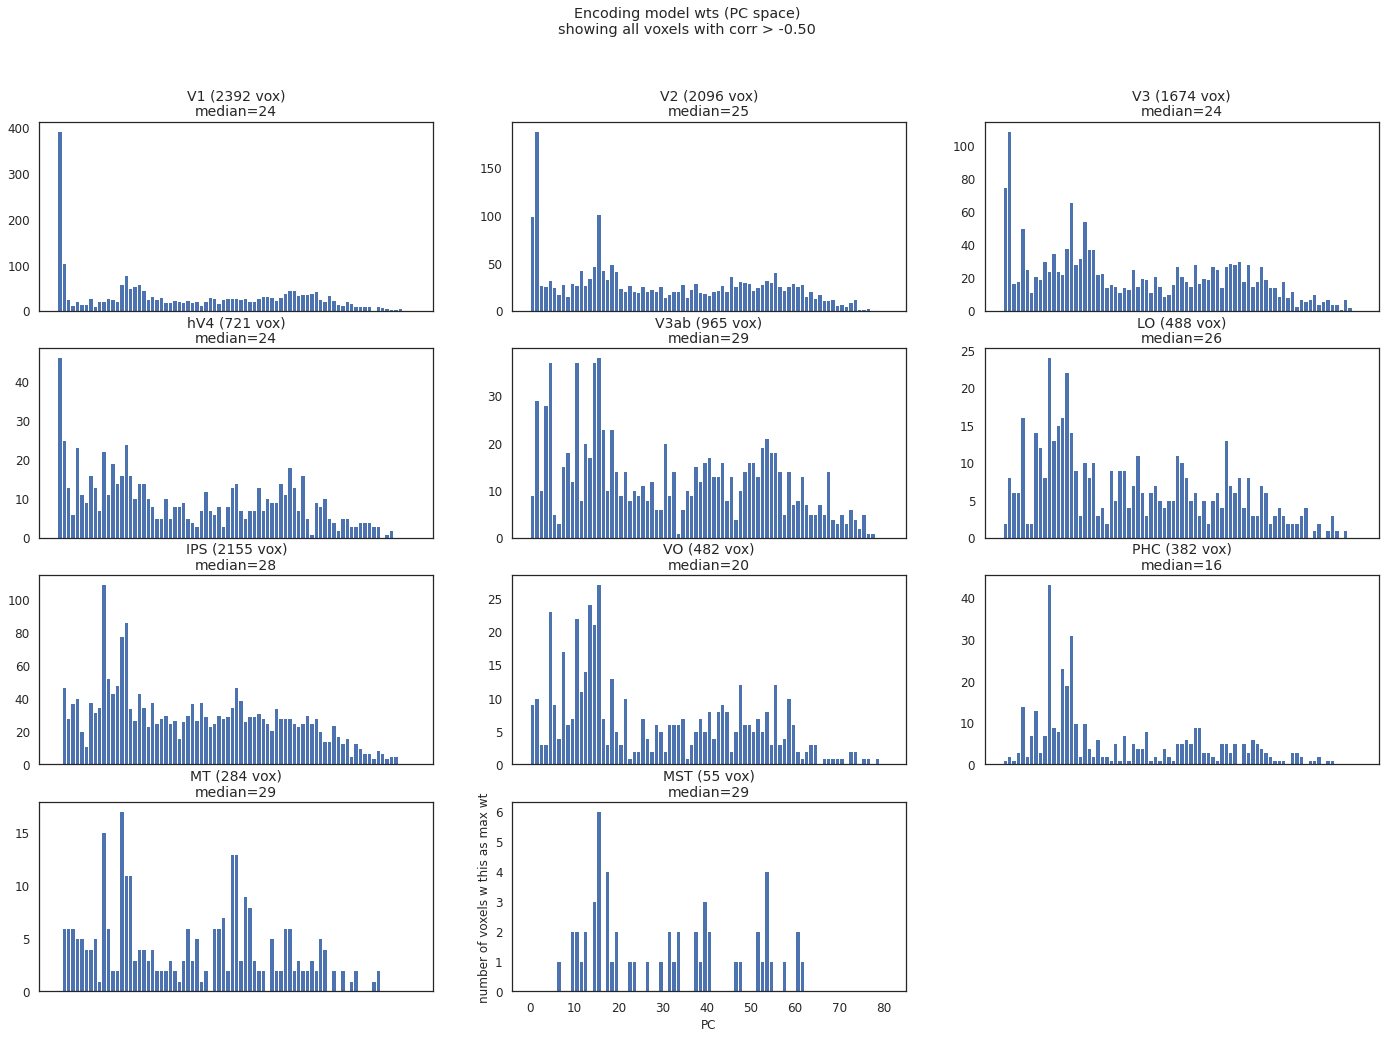

In [109]:
# Plot histogram of the orientation "tuning preferences" based on encoding model wts
plt.figure(figsize=(24,16))
npx = np.ceil(np.sqrt(n_rois))
npy = np.ceil(n_rois/npx)

wts2use = feature_weights
# un-doing the effect of z-scoring on these weights
# wts2use = wts2use / std_feats_after_pca[vidx,:] 

best_pc = np.argmax(wts2use, axis=1)

cc_cutoff = -0.5

for rr in range(n_rois-1):
        
    inds_this_roi = np.isin(voxel_roi, group[rr])
    abv_thresh = val_cc>cc_cutoff
    inds2use = np.logical_and(inds_this_roi, abv_thresh)
    
    plt.subplot(npx,npy,rr+1)
    
    h = plt.hist(best_pc[inds2use], bins=np.arange(0,np.max(n_comp_needed)));  
  
    if rr==n_rois-2:
        plt.xlabel('PC')
        plt.ylabel('number of voxels w this as max wt')
    else:
        plt.xticks([])
#         plt.yticks([])
   
    plt.title('%s (%d vox)\nmedian=%d'%(group_names[rr], np.sum(inds2use), np.median(best_pc[inds2use])))

plt.suptitle('Encoding model wts (PC space)\nshowing all voxels with corr > %.2f'%cc_cutoff);

/home/mmhender/myenv/lib/python3.7/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.


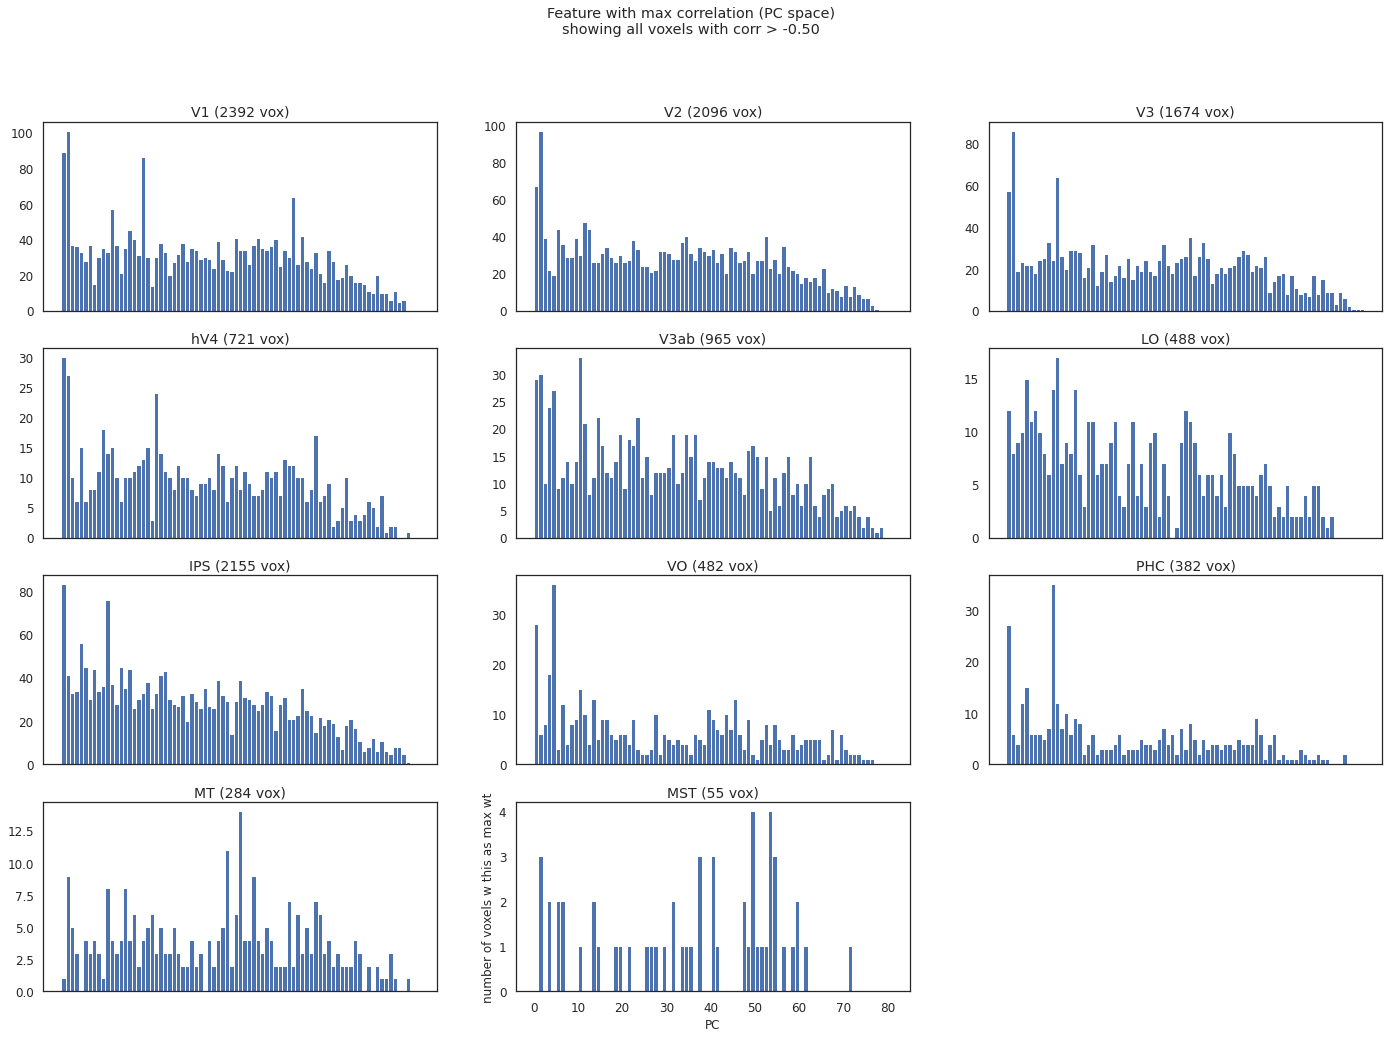

In [84]:
# Plot histogram of the orientation "tuning preferences" based on correlation coefficients
plt.figure(figsize=(24,16))
npx = np.ceil(np.sqrt(n_rois))
npy = np.ceil(n_rois/npx)

corrs2use = voxel_pca_feature_correlations_val
corrs2use[np.isnan(corrs2use)] = 0.0
best_pc = np.argmax(voxel_pca_feature_correlations_val, axis=1)

cc_cutoff = -0.5

for rr in range(n_rois-1):
        
    inds_this_roi = np.isin(voxel_roi, group[rr])
    abv_thresh = val_cc>cc_cutoff
    inds2use = np.logical_and(inds_this_roi, abv_thresh)
    
    plt.subplot(npx,npy,rr+1)
    
    h = plt.hist(best_pc[inds2use], bins=np.arange(0,np.max(n_comp_needed)));  
  
    if rr==n_rois-2:
        plt.xlabel('PC')
        plt.ylabel('number of voxels w this as max wt')
    else:
        plt.xticks([])
#         plt.yticks([])
   
    plt.title('%s (%d vox)'%(group_names[rr], np.sum(inds2use)))

plt.suptitle('Feature with max correlation (PC space)\nshowing all voxels with corr > %.2f'%cc_cutoff);

(10.0, 50.0)

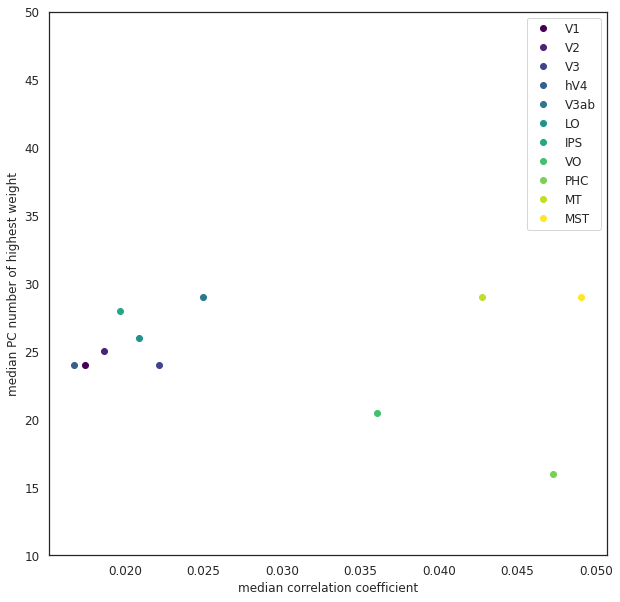

In [124]:
# Plot best encoding model wt versus corr coef for all voxels
from matplotlib.pyplot import cm
colors = cm.viridis(np.linspace(0,1,n_rois-1))
plt.figure(figsize=(10,10))
best_pc = np.argmax(feature_weights, axis=1)

cc_cutoff = -0.5

for rr in range(n_rois-1):
        
    inds_this_roi = np.isin(voxel_roi, group[rr])
    abv_thresh = val_cc>cc_cutoff
    inds2use = np.logical_and(inds_this_roi, abv_thresh)
    
    xval=np.median(val_cc[inds2use])
    yval=np.median(best_pc[inds2use])
    plt.plot(xval,yval,'o',color=colors[rr,:])

plt.legend(group_names)
plt.xlabel('median correlation coefficient')
plt.ylabel('median PC number of highest weight')
plt.ylim([10,50])
# plt.ylim([0,np.max(n_comp_needed)])

In [119]:
np.linspace(0,n_rois)

array([ 0.        ,  0.24489796,  0.48979592,  0.73469388,  0.97959184,
        1.2244898 ,  1.46938776,  1.71428571,  1.95918367,  2.20408163,
        2.44897959,  2.69387755,  2.93877551,  3.18367347,  3.42857143,
        3.67346939,  3.91836735,  4.16326531,  4.40816327,  4.65306122,
        4.89795918,  5.14285714,  5.3877551 ,  5.63265306,  5.87755102,
        6.12244898,  6.36734694,  6.6122449 ,  6.85714286,  7.10204082,
        7.34693878,  7.59183673,  7.83673469,  8.08163265,  8.32653061,
        8.57142857,  8.81632653,  9.06122449,  9.30612245,  9.55102041,
        9.79591837, 10.04081633, 10.28571429, 10.53061224, 10.7755102 ,
       11.02040816, 11.26530612, 11.51020408, 11.75510204, 12.        ])

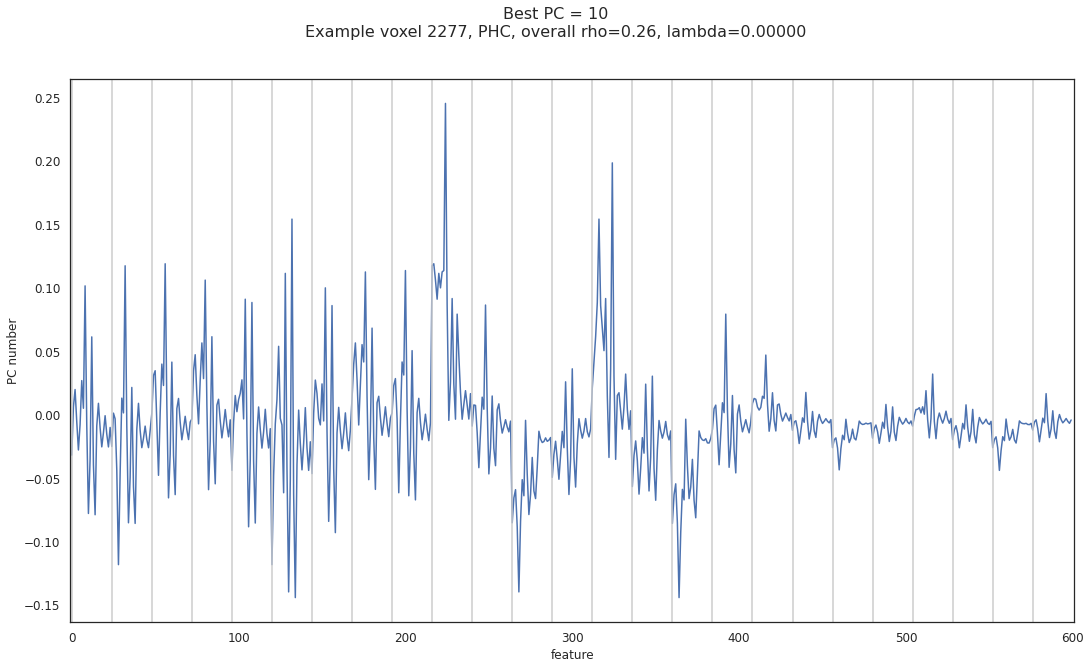

In [98]:
vidx = np.argsort(np.nan_to_num(val_cc))[-1] # choosing vox w best validation set performance
ncomp2use = n_comp_needed[best_model_inds[vidx]]

corrs2use[corrs2use==0.0] = np.nan
assert np.where(np.isnan(voxel_pca_feature_correlations_val[vidx,:]))[0][0]==ncomp2use
assert feature_weights[vidx,ncomp2use]==0.0 and not feature_weights[vidx,ncomp2use-1]==0.0

best_pc = np.argmax(feature_weights[vidx,:])
best_pc

plt.figure(figsize=(18,10))
plt.plot(pca_wts[best_pc,:, best_model_inds[vidx]])
for ii in np.arange(0,n_features*n_features+n_features, n_features):
    plt.axvline(ii,color=[0.8, 0.8, 0.8])
plt.xlabel('feature')
plt.ylabel('PC number')
plt.xlim([-1, 601])
plt.suptitle('Best PC = %d\nExample voxel %d, %s, overall rho=%.2f, lambda=%.5f'%(best_pc, vidx, group_names[roi_ind], val_cc[vidx],lambdas[int(best_lambdas[vidx])]),fontsize=16);

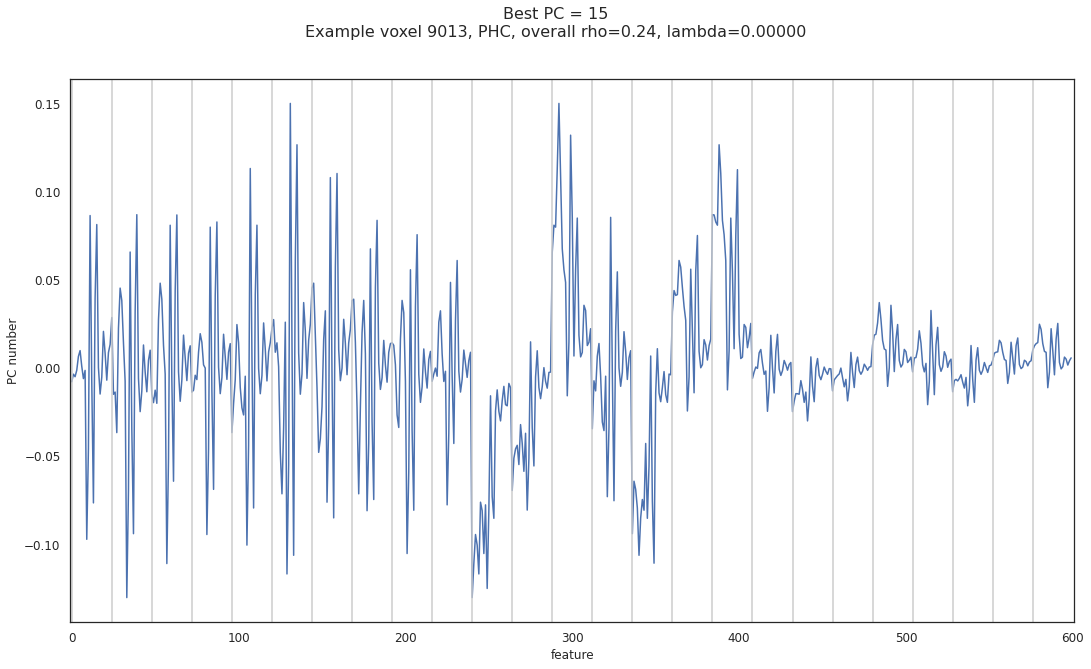

In [103]:
vidx = np.argsort(np.nan_to_num(val_cc))[-2] # choosing vox w best validation set performance
ncomp2use = n_comp_needed[best_model_inds[vidx]]

corrs2use[corrs2use==0.0] = np.nan
assert np.where(np.isnan(voxel_pca_feature_correlations_val[vidx,:]))[0][0]==ncomp2use
assert feature_weights[vidx,ncomp2use]==0.0 and not feature_weights[vidx,ncomp2use-1]==0.0

best_pc = np.argmax(feature_weights[vidx,:])
best_pc

plt.figure(figsize=(18,10))
plt.plot(pca_wts[best_pc,:, best_model_inds[vidx]])
for ii in np.arange(0,n_features*n_features+n_features, n_features):
    plt.axvline(ii,color=[0.8, 0.8, 0.8])
plt.xlabel('feature')
plt.ylabel('PC number')
plt.xlim([-1, 601])
plt.suptitle('Best PC = %d\nExample voxel %d, %s, overall rho=%.2f, lambda=%.5f'%(best_pc, vidx, group_names[roi_ind], val_cc[vidx],lambdas[int(best_lambdas[vidx])]),fontsize=16);

['/lab_data/tarrlab/common/datasets/NSD/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/FRACvalue_session01.nii.gz',
 '/lab_data/tarrlab/common/datasets/NSD/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/FRACvalue_session02.nii.gz',
 '/lab_data/tarrlab/common/datasets/NSD/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/FRACvalue_session03.nii.gz',
 '/lab_data/tarrlab/common/datasets/NSD/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/FRACvalue_session04.nii.gz',
 '/lab_data/tarrlab/common/datasets/NSD/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/FRACvalue_session05.nii.gz',
 '/lab_data/tarrlab/common/datasets/NSD/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/FRACvalue_session06.nii.gz',
 '/lab_data/tarrlab/common/datasets/NSD/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RR/FRACvalue_session07.nii.gz',
 '/lab_data/tarrlab/common/datasets/NSD/nsddata_betas/p

In [2]:
os.chdir(folder_name)


In [9]:
dir_path=folder_name
fileNames = []
for f in os.listdir(dir_path):
    print(dir_path+f)
    if os.path.isfile(dir_path+f):
        fileNames += [dir_path+f,]
fileNames

/lab_data/tarrlab/common/datasets/NSD/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RRHRFindex_session31.nii.gz
/lab_data/tarrlab/common/datasets/NSD/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RRmeanbeta_session33.nii.gz
/lab_data/tarrlab/common/datasets/NSD/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RRFRACvalue_session22.nii.gz
/lab_data/tarrlab/common/datasets/NSD/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RRR2_session13.nii.gz
/lab_data/tarrlab/common/datasets/NSD/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RRbetas_session11.nii.gz
/lab_data/tarrlab/common/datasets/NSD/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RRbetas_session13.hdf5
/lab_data/tarrlab/common/datasets/NSD/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RRR2run_session35.nii.gz
/lab_data/tarrlab/common/datasets/NSD/nsddata_betas/ppdata/subj01/func1pt8mm/betas_fithrf_GLMdenoise_RRbetas_sess

[]